# Investigation of training dataset size requirements for deep learning performance on yeast 5'UTR MPRA data 

In 2017, Cuperus et al published [this paper](https://pubmed.ncbi.nlm.nih.gov/29097404/): "Deep learning of the regulatory grammar of yeast 5' untranslated regions from 500,000 random sequences". In this study, they used CNN's to predict protein expression from randomly synthesized 50bp sequences and is a useful early example where deep learning was particualrly effective for learning expression outcomes directly from DNA sequences. 

Their original dataset contains about 500K sequences but here, I use it as a benchmark for exploring the limits of deep learning when the dataset size is reduced. I additionally compare CNN's to other model types (LSTMs and a CNN+LSTM). 

This analysis helped me deduce that using similar deep learning methods on my own _M. buryatense_ RNA-seq dataset is likely impossible due to its very limited dataset size. I found that models trained on a subset of the Cuperus dataset the same size as my _M. burytense_ dataset (n = ~2000) performed similarly to models trained on shuffled sequences (negative control).

Data access:
* Cuperus data is easily downloadable from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2793752).  (Supplementary CSV file at the bottom)
* Their original code is also available [here](https://github.com/Seeliglab/2017---Deep-learning-yeast-UTRs).

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Quick function to set random seeds for reproducibility, from [here](https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy)

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


## Load cuperus data
Download csv from [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2793752).  (Supplementary CSV file at the bottom)

In [4]:
df = pd.read_csv("data/cuperus_random_utrs.csv",index_col=0).reset_index().rename(columns={'index':'id'})
df

,id,UTR,growth_rate,t0,t1
0,0,AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...,-1.237065,14,3
1,1,AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...,1.288663,14,49
2,2,AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...,-0.608457,13,6
3,3,AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...,-1.093964,12,3
4,4,AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...,-0.048841,7,6
...,...,...,...,...,...
489343,489343,TTTTTTTGTTCCGAAGAGACCACTCAAACGTGAGCACGGCCAGACA...,1.380601,80,295
489344,489344,TTTTTTTGTTCTCTCTTCAAAATCAGTCACCCCCAGTGCGTGCACT...,0.796187,26,54
489345,489345,TTTTTTTTACAACCAGAGGATAGATTTAAGACGTCCGTCAGACCCG...,0.731318,10,20
489346,489346,TTTTTTTTATAGCTGGTTGGTACCCCTGTATGGTCTTCCGACACGG...,-0.944929,13,4


### Spot check the calculations to make sure I understand where the `growth_rate` column comes from

Published description of data generation:
1. First, a pseudocount of 1 was added to each sequence count. 
1. Sequence counts in each condition (e.g. input, random library) were then normalized to the total counts in that condition. 
1. The enrichment was calculated by log2(selection/input) -> **(Typo: they appear to have used natural log (np.log) instead of log2)**

Supplementary_files_format_and_content: .csv files. Files include columns with the UTR sequence, the raw counts for the input and following selection (t0 and t1, respectively) and the enrichment score.

In [5]:
# 1. add psuedocount
df['t0_ps'] = df['t0'] + 1
df['t1_ps'] = df['t1'] + 1

# 2. normalize counts to total counts
sum_t0 = sum(df['t0_ps'].values)
sum_t1 = sum(df['t1_ps'].values)

df['t0_norm'] = df['t0_ps']/sum_t0
df['t1_norm'] = df['t1_ps']/sum_t1

# 3. Log calculation
#df['enrich_score_log2'] = df.apply(lambda row: np.log2(row['t1_norm']/row['t0_norm']),axis=1)
#df['enrich_score_log10'] = df.apply(lambda row: np.log10(row['t1_norm']/row['t0_norm']),axis=1)
df['enrich_score'] = df.apply(lambda row: np.log(row['t1_norm']/row['t0_norm']),axis=1)

# display
df[['UTR','growth_rate','enrich_score']]

,UTR,growth_rate,enrich_score
0,AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...,-1.237065,-1.237065
1,AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...,1.288663,1.288663
2,AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...,-0.608457,-0.608457
3,AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...,-1.093964,-1.093964
4,AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...,-0.048841,-0.048841
...,...,...,...
489343,TTTTTTTGTTCCGAAGAGACCACTCAAACGTGAGCACGGCCAGACA...,1.380601,1.380601
489344,TTTTTTTGTTCTCTCTTCAAAATCAGTCACCCCCAGTGCGTGCACT...,0.796187,0.796187
489345,TTTTTTTTACAACCAGAGGATAGATTTAAGACGTCCGTCAGACCCG...,0.731318,0.731318
489346,TTTTTTTTATAGCTGGTTGGTACCCCTGTATGGTCTTCCGACACGG...,-0.944929,-0.944929


Quick plot confirming the calculated `enrich_score` values match the `growth_rate` values

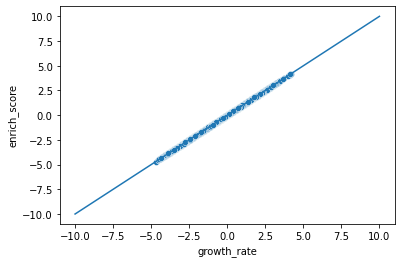

In [6]:
sns.scatterplot(data=df, x='growth_rate',y='enrich_score')
plt.plot([-10,10],[-10,10])
plt.show()

Ok, I believe I did the same calculations as used in the Cuperus paper's analysis!

### *This is the distribution we're trying to predict*

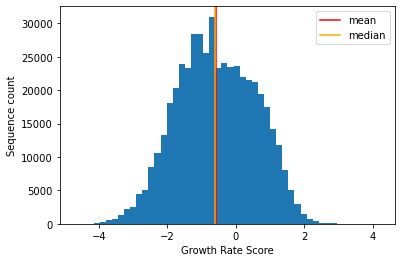

In [6]:
# histogram of values
plt.hist(data=df, x='growth_rate',bins=50)

# plot mean and median
data_mean = np.mean(df['growth_rate'].values)
data_med = np.median(df['growth_rate'].values)
plt.axvline(data_mean, color='red',label='mean')
plt.axvline(data_med, color='orange',label='median')

plt.xlabel("Growth Rate Score")
plt.ylabel("Sequence count")
plt.legend()
plt.show()

## Add Shuffled Seq Column
Even though the 50bp example sequences are randomly generated, their growth scores are true measures of that sequence's influence on expression. By shuffling the sequence, we disrupt any signals that actually influenced the experimental outcomes, so the shuffled sequence should not be well-associated with the MPRA score. Comparing the "random sequences" to "shuffled versions of random sequences" allows us to compare prediction results to null models as a negative control for predicting nonsense sequence-score associations. 


In [7]:
def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

df['shuffled_seq'] = df['UTR'].apply(lambda x: shuffle_seq(x))
df[['UTR','shuffled_seq']]

,UTR,shuffled_seq
0,AAAAAAAAAACATAATAACGATGATCAGTTAAAATCATAGTCTAAG...,TCAACAAATTTAAAACGTTACGTAGCAATAATAAGAAAAGTAATAA...
1,AAAAAAAAAAGACTACAACAGATTGTAGTGGCGGACCAGTGTGCCT...,AAGGGTAAACTAACATACGGTAGGAACAAGTACAACGGGACTTACA...
2,AAAAAAAAAATATGGGGCCCTGTTCCAAAGATACCTCAATTTCATA...,TGAATGATAGAAAACGCAATTATATACGTTTCAATCCACCAAACAA...
3,AAAAAAAAAATCTCTGGCCCGATTATACTGGAGCTAATGTAAAATT...,ACTTGAGTGAGAACAAACGAATATCTAACTTAAGTTATTCGTTAAG...
4,AAAAAAAAACATAAATATGAAGGCCTGACATTATAAATAACTTACC...,CTATAATGTAAAGTAATTGAAAATTACACAGAAAAATTATCAGACC...
...,...,...
489343,TTTTTTTGTTCCGAAGAGACCACTCAAACGTGAGCACGGCCAGACA...,TAAGTAAGACGTCTCATACTGTACATGAAGCAAGTCGGTGCCTAAC...
489344,TTTTTTTGTTCTCTCTTCAAAATCAGTCACCCCCAGTGCGTGCACT...,TCTCATAATCACTCATTGACCATCCGTTCGGGTTCTTTCGCCCACT...
489345,TTTTTTTTACAACCAGAGGATAGATTTAAGACGTCCGTCAGACCCG...,GAGTGATGTCCTCTCTTACTAACACAGGTTCTATATAAGAGTACTA...
489346,TTTTTTTTATAGCTGGTTGGTACCCCTGTATGGTCTTCCGACACGG...,GTTTTGGATTATACCCTGTGTCTGGGATGGACTCTATCACCACTTT...


## Create train/test split
At first, let's just randomly split samples between train and test (Cuperus et al do something different -  we'll try that later in this notebook, too)

In [8]:
full_train_df,test_df = tu.quick_split(df)
train_df, val_df = tu.quick_split(full_train_df)

print('full train:',full_train_df.shape)
print('test:',test_df.shape)
print('train:',train_df.shape)
print('val:',val_df.shape)

assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])

full train: (391478, 12)
test: (97870, 12)
train: (313182, 13)
val: (78296, 13)


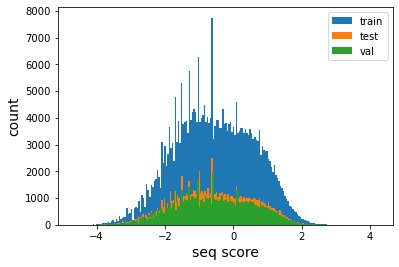

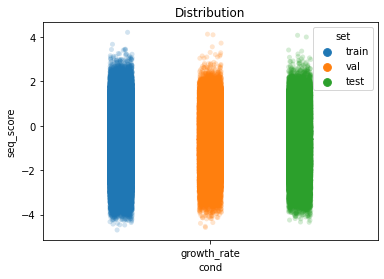

In [9]:
v.plot_train_test_hist(train_df, test_df,score_col='growth_rate',bins=200,val_df=val_df)
v.view_train_test_dist(train_df, test_df,["growth_rate"],id_col='index',val_df=val_df)

In [10]:
# hold onto these and use for prediction evaluations later
split_dfs = {
    'train':train_df,
    'val':val_df,
    'test':test_df,   
}

## Load regular (non-shuffled) seqs into PyTorch DataLoaders

In [11]:
# For now, using One-hot encoded sequence encodings (intead of K-mers, for example)
dataset_types = [
    DatasetSpec('ohe'),
]

In [12]:
seq_col = 'UTR'
target_col = 'growth_rate'

dls = tu.build_dataloaders(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
)

ohe_train_dl,ohe_val_dl = dls['ohe']

# get ready to collect results from a few models
model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col].values[0])

## Run model 

In [ ]:
cnn1_name = "5UTR regression quicksplit"

# Use a basic CNN with 2 convolutional layers and 2 fully connected layers
model1 = m.DNA_2CNN_2FC(
    seq_len, # length of input seqs
    num_classes=1, # single-value prediction
)

# model is run in "collect_model_stats()" with several default values selected
model_res[cnn1_name] = tu.collect_model_stats(
    cnn1_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model1,
    loss_type='regression'
)

E:277 | train loss:0.694 | val loss: 0.687:  14%|█▍        | 278/2000 [48:13<4:57:40, 10.37s/it]

EarlyStopping counter: 50 out of 200


E:344 | train loss:0.693 | val loss: 0.687:  17%|█▋        | 345/2000 [59:48<4:44:53, 10.33s/it]

EarlyStopping counter: 50 out of 200


E:394 | train loss:0.691 | val loss: 0.684:  20%|█▉        | 395/2000 [1:08:27<4:36:09, 10.32s/it]

EarlyStopping counter: 100 out of 200


E:444 | train loss:0.692 | val loss: 0.692:  22%|██▏       | 445/2000 [1:17:03<4:28:37, 10.36s/it]

EarlyStopping counter: 150 out of 200


E:473 | train loss:0.691 | val loss: 0.684:  24%|██▎       | 474/2000 [1:22:04<4:23:54, 10.38s/it]

### check `model1` predictions
Create parity plot for each dataset split with `parity_pred_by_split()`

/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


val split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


test split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


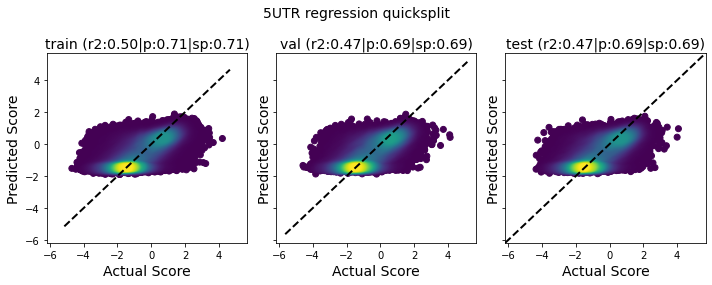

In [14]:
pred_dfs[cnn1_name] = tu.parity_pred_by_split(
    model1,
    cnn1_name,
    DEVICE,
    split_dfs,
    locus_col='index',
    seq_col=seq_col,
    target_col=target_col,
    splits=['train','val','test']
)

_Parity plot: each point is an example sequence in the dataset with its experimentally measured score on the x-axis and the model-predicted score on the y-axis. Points are colored by density to show where the data is plotted most densely. `r2` = R2 score, `p` = pearson corrleation, `sp` = spearman correlation_ 

So this model's r2 score on the test set is about 0.47... not as good as their 0.62 in the paper.  

Let's try with a slightly faster learning rate?

E:253 | train loss:0.703 | val loss: 0.692:  13%|█▎        | 254/2000 [43:52<5:00:59, 10.34s/it]

EarlyStopping counter: 50 out of 200


E:312 | train loss:0.703 | val loss: 0.690:  16%|█▌        | 313/2000 [54:03<4:51:28, 10.37s/it]

EarlyStopping counter: 50 out of 200


E:362 | train loss:0.700 | val loss: 0.698:  18%|█▊        | 363/2000 [1:02:42<4:44:47, 10.44s/it]

EarlyStopping counter: 100 out of 200


E:431 | train loss:0.699 | val loss: 0.700:  22%|██▏       | 432/2000 [1:14:39<4:30:47, 10.36s/it]

EarlyStopping counter: 50 out of 200


E:481 | train loss:0.698 | val loss: 0.700:  24%|██▍       | 482/2000 [1:23:15<4:21:16, 10.33s/it]

EarlyStopping counter: 100 out of 200


E:531 | train loss:0.698 | val loss: 0.695:  27%|██▋       | 532/2000 [1:31:51<4:12:23, 10.32s/it]

EarlyStopping counter: 150 out of 200


E:581 | train loss:0.698 | val loss: 0.698:  29%|██▉       | 581/2000 [1:40:27<4:05:20, 10.37s/it]

EarlyStopping counter: 200 out of 200
Early stopping


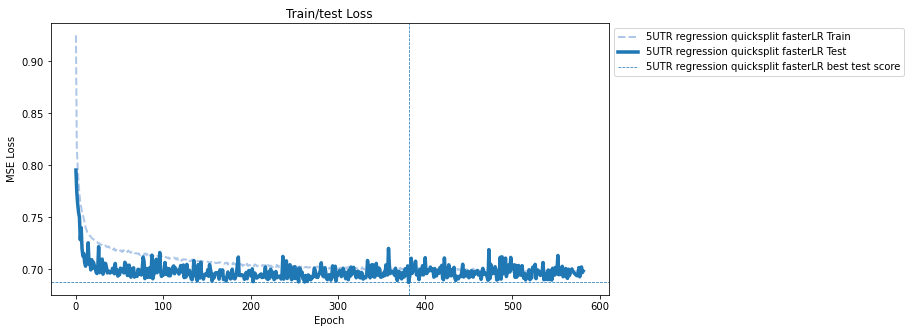

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit fasterLR


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


val split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit fasterLR


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


test split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit fasterLR


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


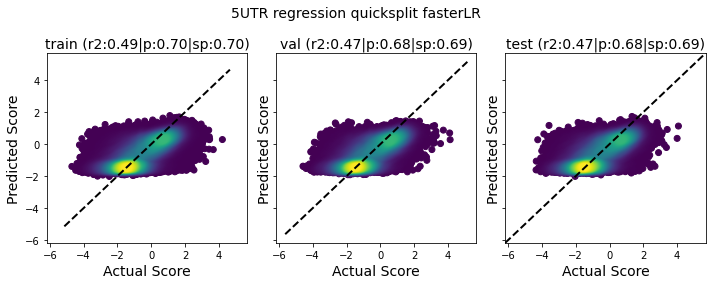

In [15]:
cnn2_name = "5UTR regression quicksplit fasterLR"
model2 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=1,
)

model_res[cnn2_name] = tu.collect_model_stats(
    cnn2_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model2,
    loss_type='regression'
)

pred_dfs[cnn2_name] = tu.parity_pred_by_split(
    model2,
    cnn2_name,
    DEVICE,
    split_dfs,
    locus_col='index',
    seq_col=seq_col,
    target_col=target_col,
    splits=['train','val','test']
                    )

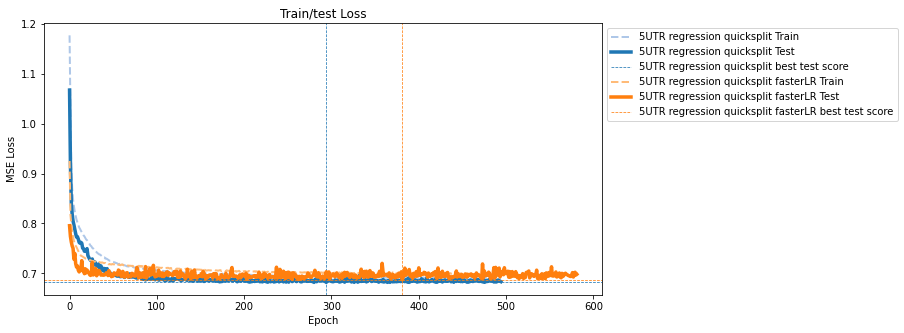

In [16]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

So far, no real difference in performance between the learning rates. Let's compare these results to training a model on the shuffled versions of the sequences (this is a negative control since relevant biological UTR signals should be destroyed in the shuffling)

# Shuffled sequences
### Reload dataloaders with shuffled seqs

In [17]:
seq_col_name = 'shuffled_seq'
target_col_name = 'growth_rate'

# Shuffled data loaders
dls_shuff = tu.build_dataloaders(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)

shuff_ohe_train_dl,shuff_ohe_val_dl = dls_shuff['ohe']

E:63 | train loss:1.190 | val loss: 1.199:   3%|▎         | 64/2000 [11:06<5:36:40, 10.43s/it]

EarlyStopping counter: 50 out of 200


E:113 | train loss:1.178 | val loss: 1.204:   6%|▌         | 114/2000 [19:48<5:27:44, 10.43s/it]

EarlyStopping counter: 100 out of 200


E:163 | train loss:1.170 | val loss: 1.214:   8%|▊         | 164/2000 [28:27<5:19:09, 10.43s/it]

EarlyStopping counter: 150 out of 200


E:213 | train loss:1.166 | val loss: 1.215:  11%|█         | 213/2000 [37:08<5:11:39, 10.46s/it]

EarlyStopping counter: 200 out of 200
Early stopping


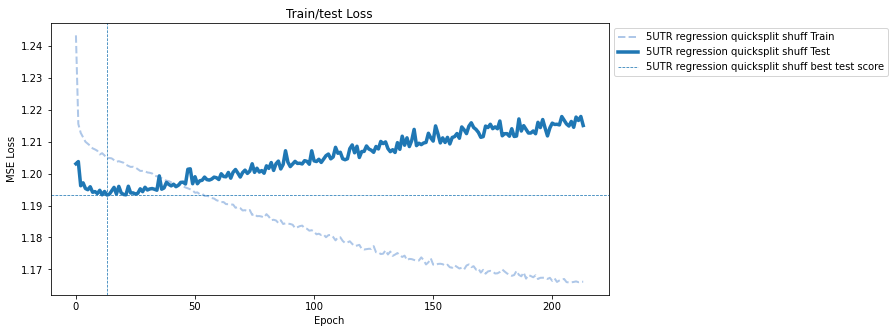

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit shuff


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


val split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit shuff


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


test split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression quicksplit shuff


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


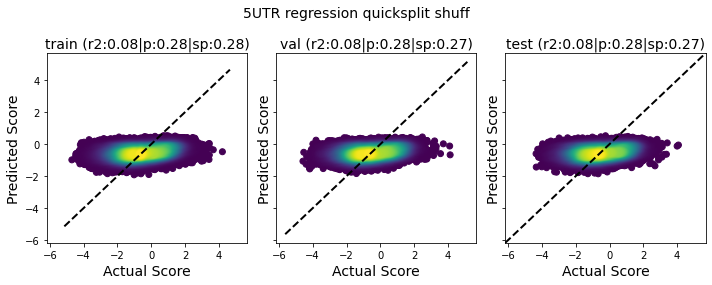

In [18]:
cnn3_name = "5UTR regression quicksplit shuff"
model3 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=1,
)

model_res[cnn3_name] = tu.collect_model_stats(
    cnn3_name,
    seq_len,
    shuff_ohe_train_dl,
    shuff_ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model3,
    loss_type='regression'
)

pred_dfs[cnn3_name] = tu.parity_pred_by_split(
    model3,
    cnn3_name,
    DEVICE,
    split_dfs,
    locus_col='index',
    seq_col=seq_col,
    target_col=target_col,
    splits=['train','val','test']
                    )

At a quick glance, this shuffled-sequence model is clearly worse! (as expected). The R2 is only 0.08 instead of 0.46. We can further see the discrepancies in the training loss plots:

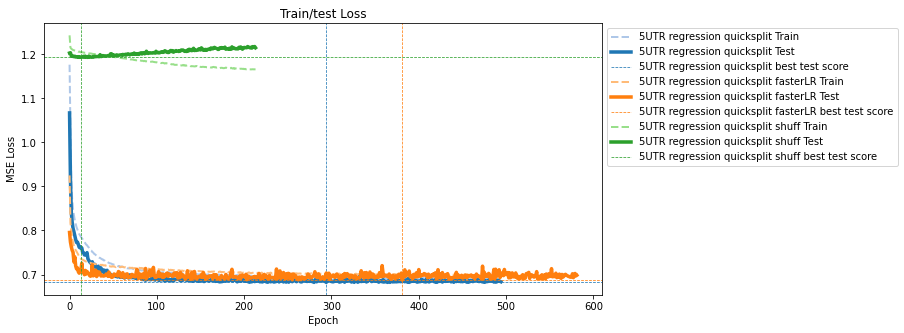

In [19]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

# Now try with top 5% of samples with most reads as test set

In the Cuperus et al paper, instead of using a random train/test split, they took the top 5% of sequences that had the highest initial count (highest `t0` values) and used those as a "high quality test set." The reasoning was that because these sequences started with the most read counts, observing their relative changes would probably have less noise and therefore be higher quality. (So we're training on the noisier data but testing on less noisy data) 

So let's try again while using the same train/test split method from their paper.

In [20]:
def top_n_split(df, n, sort_col):
    '''
    Given a value n, take the top n% of reads and use those as the test split.
    '''
    sorted_df = df.sort_values(sort_col,ascending=False)
    
    total_samples = df.shape[0]
    num_test_samples = int(n*total_samples)
    test_df = sorted_df.head(num_test_samples)
    train_df = sorted_df.tail(total_samples - num_test_samples)
    
    return train_df, test_df

In [21]:
full_train_df,test_df = top_n_split(df, 0.05, 't0')
train_df, val_df = tu.quick_split(full_train_df)

print('full train:',full_train_df.shape)
print('test:',test_df.shape)
print('train:',train_df.shape)
print('val:',val_df.shape)

assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])

split_dfs = {
    #'full_train':full_train_df,
    'train':train_df,
    'val':val_df,
    'test':test_df.reset_index(),   
}

full train: (464881, 11)
test: (24467, 11)
train: (371904, 12)
val: (92977, 12)


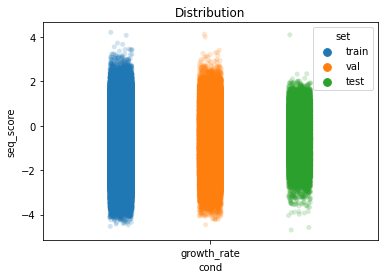

In [22]:
v.view_train_test_dist(train_df, test_df,["growth_rate"],id_col='index',val_df=val_df)

From this plot, it looks like the "high quality test set" has a more limited value range?

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


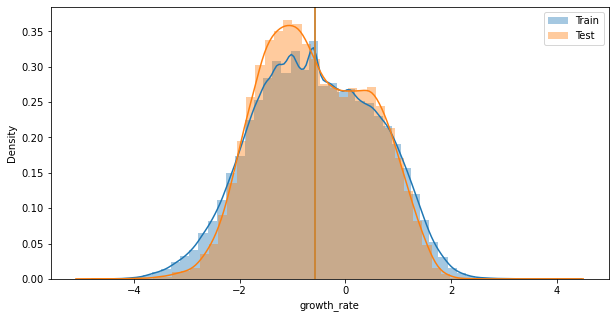

In [23]:
fig = plt.figure(figsize=(10,5))
sns.distplot(train_df['growth_rate'],label="Train")
sns.distplot(test_df['growth_rate'],label="Test")
plt.axvline(np.mean(train_df['growth_rate'].values),color='blue')
plt.axvline(np.mean(test_df['growth_rate'].values),color='orange')
plt.legend()
plt.show()

Indeed, there is a slightly different distribution of values from the training set... I'm not sure if this is significant or not. Maybe by testing your model on sequences that contain fewer examples at the extremes of the distribution make your evaluation over-estimating the quality of your model? 

In any case, I move forward here with this alternative test set to make sure I can recreate the results of the paper. *shrug*

### Put this new train/test split into data loaders

In [24]:
dataset_types = [
    DatasetSpec('ohe'),
]

seq_col_name = 'UTR'
target_col_name = 'growth_rate'

# Data loaders for "top 5% split"
dls = tu.build_dataloaders(
    train_df, 
    val_df, 
    dataset_types,
    seq_col=seq_col_name,
    target_col=target_col_name,
)


ohe_train_dl,ohe_val_dl = dls['ohe']

model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col_name].values[0])

### Run models on top 5% split

E:165 | train loss:0.716 | val loss: 0.710:   8%|▊         | 166/2000 [34:25<6:20:41, 12.45s/it]

EarlyStopping counter: 50 out of 200


E:225 | train loss:0.714 | val loss: 0.712:  11%|█▏        | 226/2000 [46:53<6:08:20, 12.46s/it]

EarlyStopping counter: 50 out of 200


E:275 | train loss:0.712 | val loss: 0.725:  14%|█▍        | 276/2000 [57:15<5:55:40, 12.38s/it]

EarlyStopping counter: 100 out of 200


E:325 | train loss:0.711 | val loss: 0.714:  16%|█▋        | 326/2000 [1:07:36<5:47:38, 12.46s/it]

EarlyStopping counter: 150 out of 200


E:375 | train loss:0.710 | val loss: 0.729:  19%|█▉        | 375/2000 [1:17:57<5:37:48, 12.47s/it]

EarlyStopping counter: 200 out of 200
Early stopping


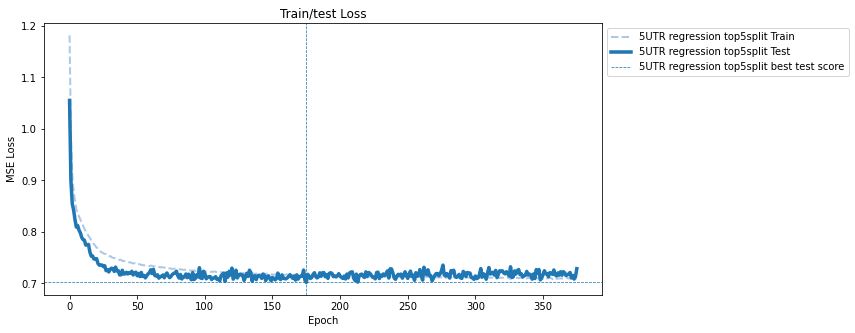

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression top5split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


val split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression top5split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


test split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]


Predicting for 5UTR regression top5split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:956: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]


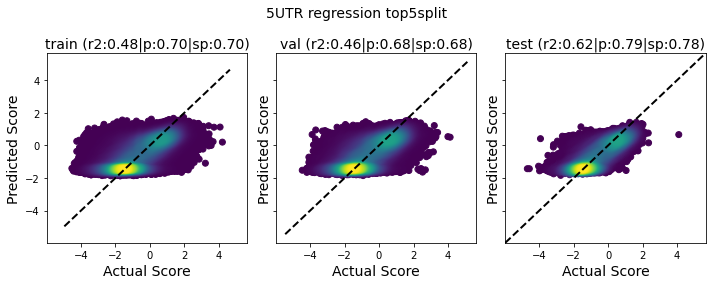

In [25]:
cnn5_name = "5UTR regression top5split"
model5 = m.DNA_2CNN_2FC(
    seq_len,
    num_classes=1,
)

model_res[cnn5_name] = tu.collect_model_stats(
    cnn5_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=2000,
    pat=200,
    opt=torch.optim.Adam,
    model=model5,
    loss_type='regression'
)

pred_dfs[cnn5_name] = tu.parity_pred_by_split(
    model5,
    cnn5_name,
    DEVICE,
    split_dfs,
    locus_col='index',
    seq_col=seq_col,
    target_col=target_col,
    splits=['train','val','test'], 
)

NOW the test split R2 score matches what Cuperus found in their paper (0.62)! It appears that using the Top 5% test split was influential for acheiving better prediction performance. 

### look at model convolutional filters

Total convolutional layers: 2
Num filters 32
filt_width 8
Seq 0 of 5000
Seq 100 of 5000
Seq 200 of 5000
Seq 300 of 5000
Seq 400 of 5000
Seq 500 of 5000
Seq 600 of 5000
Seq 700 of 5000
Seq 800 of 5000
Seq 900 of 5000
Seq 1000 of 5000
Seq 1100 of 5000
Seq 1200 of 5000
Seq 1300 of 5000
Seq 1400 of 5000
Seq 1500 of 5000
Seq 1600 of 5000
Seq 1700 of 5000
Seq 1800 of 5000
Seq 1900 of 5000
Seq 2000 of 5000
Seq 2100 of 5000
Seq 2200 of 5000
Seq 2300 of 5000
Seq 2400 of 5000
Seq 2500 of 5000
Seq 2600 of 5000
Seq 2700 of 5000
Seq 2800 of 5000
Seq 2900 of 5000
Seq 3000 of 5000
Seq 3100 of 5000
Seq 3200 of 5000
Seq 3300 of 5000
Seq 3400 of 5000
Seq 3500 of 5000
Seq 3600 of 5000
Seq 3700 of 5000
Seq 3800 of 5000
Seq 3900 of 5000
Seq 4000 of 5000
Seq 4100 of 5000
Seq 4200 of 5000
Seq 4300 of 5000
Seq 4400 of 5000
Seq 4500 of 5000
Seq 4600 of 5000
Seq 4700 of 5000
Seq 4800 of 5000
Seq 4900 of 5000
torch.Size([32, 4, 8])


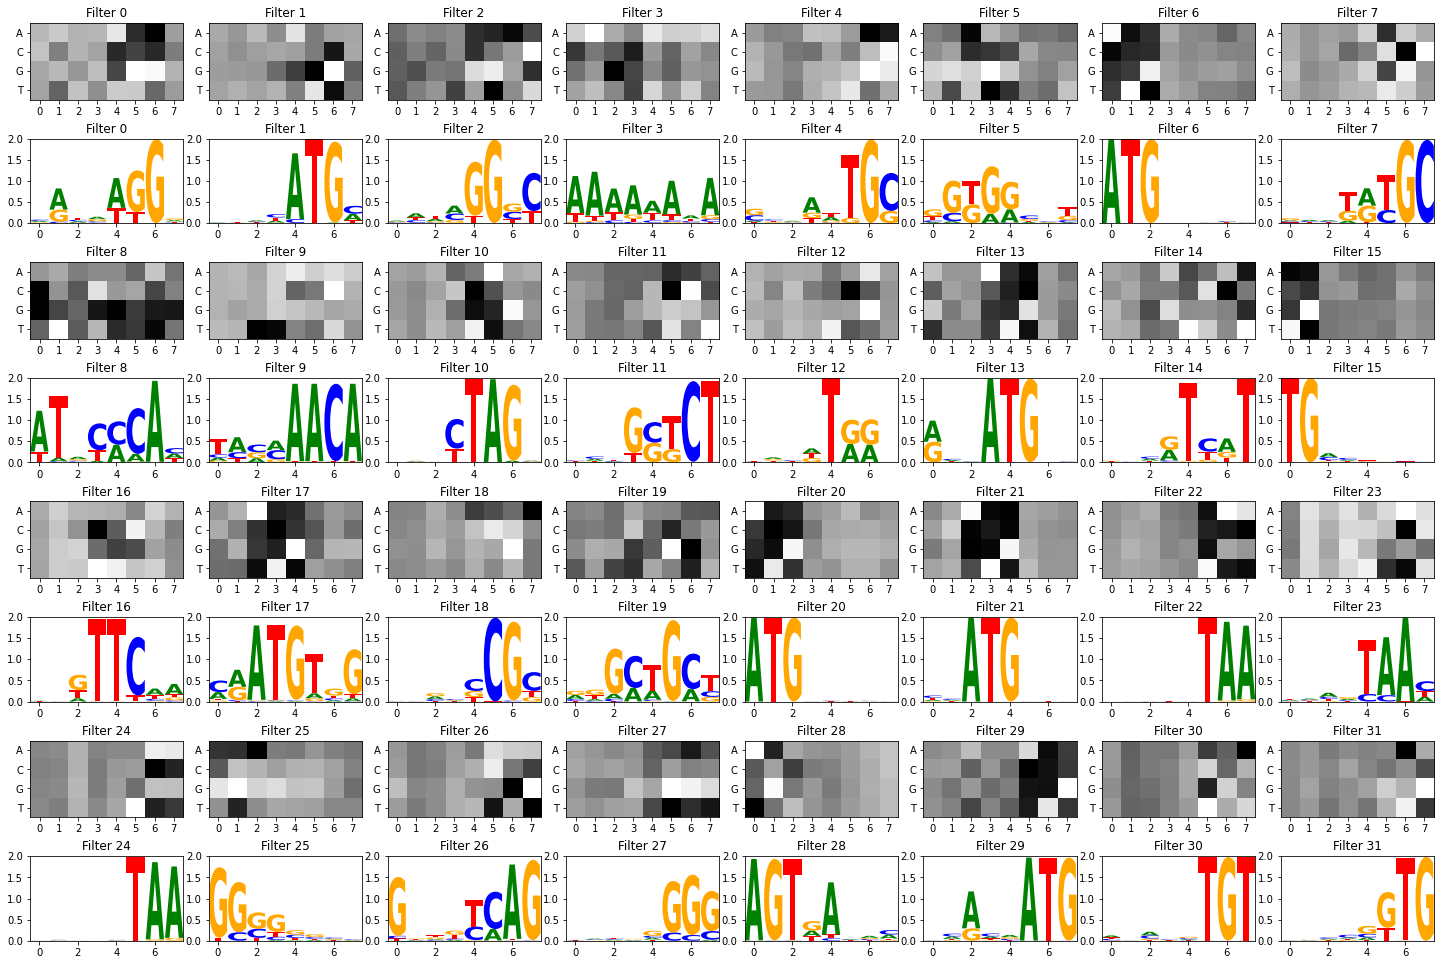

In [27]:
# grab some sequences from which to extract convolutional filter activations 
# (the exact sequences don't really matter - they're just helping us see the filters)
seqs = test_df['UTR'].values[:5000]
v.view_conv2D_wrapper(model5,seqs,DEVICE,act_thresh=0.5,ysc=0.75)

Similar to the findings discussed in Cuperus et al, many of the first layer convolutional filters learn to detect start codons and stop codons, which are highly influential in expression strength due to the creation of upstream ORFs in 5' UTRs (which can confuse the ribosome and lead to lower expression).

### Recreate figure from Cuperus et al paper
For completeness, let's recreate their parity plot from their paper/code online

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predicting for 5UTR regression top5split


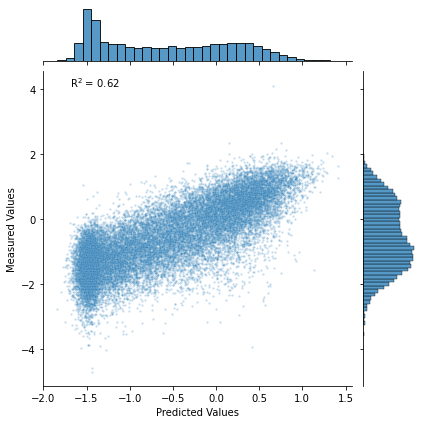

In [29]:
locus_col = 'id'
seq_col = 'UTR'
target_col = 'growth_rate'
split='test'
model_name = cnn5_name
model = model5


my_df = split_dfs[split]
loci = my_df[locus_col].values
seqs = list(my_df[seq_col].values)        
ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(DEVICE)

# initialize prediction df with just locus col
pred_df = my_df[[locus_col]]
pred_df['truth'] = my_df[target_col]
print(f"Predicting for {model_name}")


# ask model to predict on seqs
preds = model(ohe_seqs.float()).tolist()
# preds is a tensor converted to a list, 
# single elements returned as a list, hence x[0]
pred_df['pred'] = [x[0] for x in preds]

# make the plot
ax = sns.jointplot(data = pred_df, x='pred',y='truth',alpha=0.25,s=5)
ax.ax_joint.set_xlabel("Predicted Values")
ax.ax_joint.set_ylabel("Measured Values")

# calculate R2 score
ytrue = pred_df['truth'].values
ypred = pred_df['pred'].values
r2 = r2_score(ytrue,ypred)

text = f"R$^2$ = {r2:0.2}"
plt.annotate(text, xy=(-5.5, 0.95), xycoords='axes fraction')

plt.show()

Correpsonding image from Cuperus et al [notebook](https://github.com/Seeliglab/2017---Deep-learning-yeast-UTRs/blob/master/Jupyter_notebooks/Notebook_2_CNN_Predictions_of_Random_UTR_HIS3_data.ipynb).

<img src="./img/cuperus_plot.png" 
     align="left" 
     width="450" />
     

So we've verified that we can build a model that predicts the Cuperus et al MPRA data as well as they did in the paper. Notably, we didn't jump through hoops to use the exact same CNN architecture and the model worked just fine (in fact, the one used in this notebook is maybe half the size?). Maybe there's more optimization that could lead to performance improvements, but for now its enough to verify that we're performing as well as the model in the publication. 

In [30]:
# stucture of the CNN used here, which is a bit smaller/simpler than Cuperus'
model5

DNA_2CNN_2FC(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=1152, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=1, bias=True)
  )
)

Final optimized CNN arch from Cuperus et al

<img src="./img/cuperus_CNN_arch.png" 
     align="left" 
     width="600" />

# Training data size reduction
Next, we experimented with systematically reducing the training data set size to see where the model's ability to predict the UTR signal breaks. Since these trainings took a while to run, we set up a script `mpra_reduction.py` to loop through various models and collect prediction performances. The script was executed on an HPC GPU cluster and results saved in `out_mpra_reduction/mpra_reduction_results.tsv`. 

The main variations we tested are:
* Data set size: the full UTR data set contains ~500,000 sequences. We reduced this by subsampling the dataset at
    * 1.0 (training set _n_ = 370K)
    * 0.25 (training set _n_ = 93K)
    * 0.025 (training set _n_ = 9K)
    * 0.005 (training set _n_ = 1.8K)
* Model architecture
    * CNN
    * Bidirectional LSTM
    * CNN + Bidirectional LSTM

Below, we summarize the 5-fold cross-validation results. 

## Visualizing reduction results
Performance results collected from running `mpra_reduction.py` on the UW HPC cluster. 5 different models were trained for each reduction size, each using a different split of the train set. The test split was the same for each.

In [31]:
res_df = pd.read_csv('out_mpra_reduction/mpra_reduction_results.tsv',sep='\t')
res_df

,model_name,split,r2,pearson,spearman,reduction,train_size,cv_fold,seq_mode,model_type
0,biLSTM_cv3_r0.25_shuffleSeqs,val,0.080846,0.284574,0.280800,0.250,92976,3,shuffle,biLSTM
1,biLSTM_cv3_r0.25_shuffleSeqs,test,0.068621,0.264982,0.255763,0.250,92976,3,shuffle,biLSTM
2,CNN_cv4_r0.025_regularSeqs,train,0.473928,0.689140,0.691225,0.025,9298,4,regular,CNN
3,CNN_cv4_r0.025_regularSeqs,val,0.387334,0.622663,0.623330,0.025,9298,4,regular,CNN
4,CNN_cv4_r0.025_regularSeqs,test,0.437665,0.664764,0.669171,0.025,9298,4,regular,CNN
...,...,...,...,...,...,...,...,...,...,...
301,CNNLSTM_cv1_r0.025_shuffleSeqs,train,0.074027,0.273231,0.266495,0.025,9298,1,shuffle,CNNLSTM
302,CNNLSTM_cv1_r0.025_shuffleSeqs,val,0.075719,0.276090,0.261001,0.025,9298,1,shuffle,CNNLSTM
303,CNNLSTM_cv1_r0.025_shuffleSeqs,test,0.050101,0.232054,0.232955,0.025,9298,1,shuffle,CNNLSTM
304,biLSTM_cv0_r1.0_shuffleSeqs,val,0.078972,0.281029,0.277851,1.000,371904,0,shuffle,biLSTM


In [32]:
# Looking at the dataset "reduction" and correpsonding "train set size"
res_df[['reduction','train_size']].drop_duplicates()

,reduction,train_size
0,0.250,92976
2,0.025,9298
7,0.005,1860
12,1.000,371905
74,1.000,371904


### Focus on the results for the 'test' splits
Filter to only the `test` split prediction scores

In [33]:
# use the results of all the test splits 
res_df_test = res_df[res_df['split']=='test']

# separate by regular vs shuffled sequences
res_df_reg_test = res_df_test[res_df_test['seq_mode']=='regular']
res_df_shuff_test = res_df_test[res_df_test['seq_mode']=='shuffle']

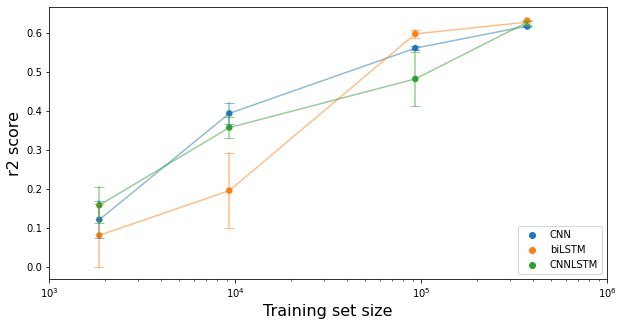

In [34]:
fig = plt.figure(figsize=(10,5))
hue_order = ['CNN','biLSTM','CNNLSTM']

# Plot dots (average R2 score)
ax = sns.scatterplot(data=res_df_reg_test.groupby(['reduction','model_type']).mean().reset_index(),
                x='train_size',y='r2',s=50,hue='model_type',hue_order=hue_order)

# Make legend not annoyingly terrible
handles = ax.legend_.legendHandles[:]
labels = [text.get_text() for text in ax.legend_.texts][:]

# plot line for each model with error bars for r2 standard deviations
sns.lineplot(data=res_df_reg_test,
             x='train_size',y='r2',hue='model_type',ci='sd',err_style='bars',
             alpha=0.5,hue_order=hue_order,err_kws={'capsize':5})

# label nicely
plt.xscale('log')
plt.xticks([1000,10000,100000,1000000])
plt.ylabel("r2 score",fontsize=16)
plt.xlabel("Training set size",fontsize=16)
plt.legend(handles, labels,loc='lower right')
plt.show()

For each of the model types, we can see the R2 prediction peformance drops as the training set size drops (5 fold cross validation across the train set)

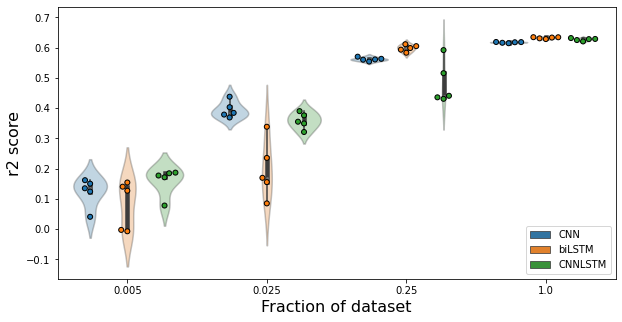

In [35]:
# Same plot but as a violin/swarmplot combo
fig = plt.figure(figsize=(10,5))

# make violins
ax = sns.violinplot(data=res_df_reg_test,x='reduction',y='r2',hue='model_type',dodge=True,legend=False)
# make violin color a little more muted
plt.setp(ax.collections,alpha=0.3)

# fix legend labels
handles = ax.legend_.legendHandles
labels = [text.get_text() for text in ax.legend_.texts]

# overlay swarmplot
sns.swarmplot(data=res_df_reg_test,x='reduction',y='r2',
              hue='model_type',dodge=True,edgecolor='black',
              linewidth=1,ax=ax)

# Label nicely
plt.legend(handles, labels,loc='lower right')
plt.ylabel("r2 score",fontsize=16)
plt.xlabel("Fraction of dataset",fontsize=16)
plt.show()

This is the same performance plot but showing more detail about the 5 individual splits. There seems to be a bit more variability in performance across the models containing LSTM components for smaller training sets.

Notably, the 0.005 fraction of the dataset trains on 1860 sequences. This is about the same size as the M. buryatense promoter dataset I've been investigating. Sadly, performance is quite low.

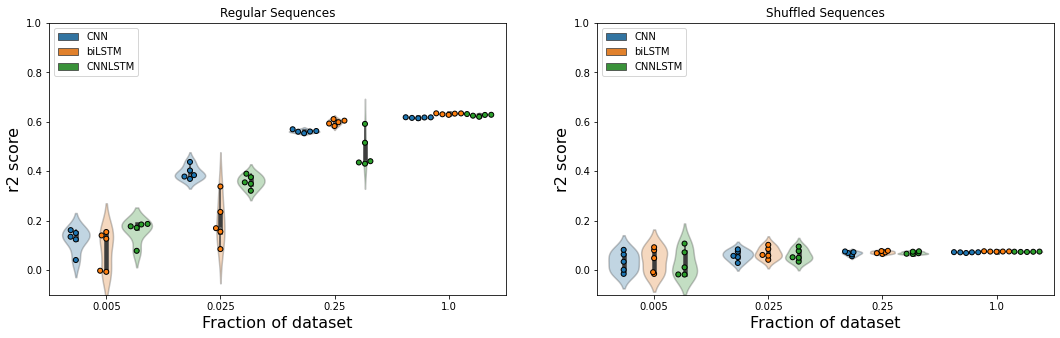

In [36]:
hue_order = ['CNN','biLSTM','CNNLSTM']

fig,axes = plt.subplots(1,2,figsize=(18,5))

# +-------------------+
# | Regular sequences |
# +-------------------+
sns.violinplot(data=res_df_reg_test,x='reduction',y='r2',hue='model_type',
               dodge=True,legend=False,ax=axes[0], hue_order=hue_order)
plt.setp(axes[0].collections,alpha=0.3)

handles = axes[0].legend_.legendHandles
labels = [text.get_text() for text in axes[0].legend_.texts]

sns.swarmplot(data=res_df_reg_test,x='reduction',y='r2',hue='model_type',
              dodge=True,edgecolor='black',linewidth=1,ax=axes[0],hue_order=hue_order)

axes[0].legend(handles, labels,loc='upper left')
axes[0].set_ylim(-0.1,1.0)

axes[0].set_ylabel("r2 score",fontsize=16)
axes[0].set_xlabel("Fraction of dataset",fontsize=16)
axes[0].set_title("Regular Sequences")

# +--------------------+
# | Shuffled sequences |
# +--------------------+
sns.violinplot(data=res_df_shuff_test,x='reduction',y='r2',hue='model_type',
               dodge=True,legend=False,ax=axes[1], hue_order=hue_order)
plt.setp(axes[1].collections,alpha=0.3)

handles = axes[1].legend_.legendHandles
labels = [text.get_text() for text in axes[1].legend_.texts]

sns.swarmplot(data=res_df_shuff_test,x='reduction',y='r2',hue='model_type',
              dodge=True,edgecolor='black',linewidth=1,ax=axes[1], hue_order=hue_order)
axes[1].legend(handles, labels,loc='upper left')
axes[1].set_ylim(-0.1,1.0)


axes[1].set_ylabel("r2 score",fontsize=16)
axes[1].set_xlabel("Fraction of dataset",fontsize=16)
axes[1].set_title("Shuffled Sequences")
plt.show()

Unsurprisingly, the models' performance goes down as you decrease the training data. Performance generally remains higher than the same model architectures trained on shuffled sequences as a negative control, however the difference between regular and shuffled models for the 0.005 fraction of the datasets are quite similar, indicating that this type of model cannot make predictions much better than random as this data scale. 

# Concluding thoughts

At the smallest training set tried here (~1,800 examples from a 0.005 dataset reduction), performance is nearly the same as random sequences. This is about the same size of the _M. buryatense_ RNA-seq dataset I was originally using. Therefore it seems highly unlikely that a model trained solely on the _M. buryatense_ set could work at all. 

Thus, we suggest that some sort of additional pre-training/transfer learning tactics are necessary for these types of deep learning to be effective with the _M. buryatense_ data. Viewing the training results from the Cuperus MPRA experiment - which is not exactly the same as our data but has similarities and is a useful point of comparison - helped us better understand the limits of deep learning approaches for small genomic datasets.